In [8]:
import requests
import functools
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from tqdm import tqdm, tqdm_notebook

def getSources():
    source_url = 'https://newsapi.org/v1/sources?language=en'
    response = requests.get(source_url).json()
    sources = []
    for source in response['sources']:
        sources.append(source['id'])
    return sources

def mapping():
    d = {}
    response = requests.get('https://newsapi.org/v1/sources?language=en')
    response = response.json()
    for s in response['sources']:
        d[s['id']] = s['category']
    return d

def category(source, m):
    try:
        return m[source]
    except:
        return 'NC'

def getDailyNews():
    sources = getSources()
    key = 'a4f9690e27f342cd8bf764dc9cf26097'
    url = 'https://newsapi.org/v1/articles?source={0}&sortBy={1}&apiKey={2}'
    responses = []
    for i, source in tqdm_notebook(enumerate(sources), total=len(sources)):
        
        try:
            u = url.format(source, 'top', key)
        except:
            u = url.format(source, 'latest', key)
        
        response = requests.get(u)
        r = response.json()
        try:
            for article in r['articles']:
                article['source'] = source
            responses.append(r)
        except:
            print('Rate limit exceeded ... please wait and retry in 6 hours')
            return None
                
    articles = list(map(lambda r: r['articles'], responses))
    #articles = list(reduce(lambda x,y: x+y, articles))
    articles = list(functools.reduce(lambda x,y: x+y, articles))

    
    news = pd.DataFrame(articles)
    news = news.dropna()
    news = news.drop_duplicates()
    news.reset_index(inplace=True, drop=True)
    d = mapping()
    news['category'] = news['source'].map(lambda s: category(s, d))
    news['scraping_date'] = datetime.now()

    try:
        aux = pd.read_csv('data/news.csv')
        aux = aux.append(news)
        aux = aux.drop_duplicates('url')
        aux.reset_index(inplace=True, drop=True)
        aux.to_csv('data/news.csv', encoding='utf-8', index=False)
    except:
        news.to_csv('data/news.csv', index=False, encoding='utf-8')
        
    print('Done')
    
if __name__=='__main__':
    getDailyNews()

Done


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\firman1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\firman1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(353, 9)
(332, 9)
(144, 9)


,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,Tristan Greene,Scientists may have found a potential cure for...,2019-08-14T21:42:43Z,the-next-web,Boosting a single brain molecule cured anxiety...,https://thenextweb.com/insights/2019/08/14/boo...,https://img-cdn.tnwcdn.com/image/tnw?filter_la...,technology,2019-08-15 09:45:27.206260
1,John Binder,Sen. Kamala Harris (D-CA) has continued her de...,2019-08-14T15:33:58Z,breitbart-news,Poll: Kamala Harris Falls to Sixth Place Among...,http://www.breitbart.com/politics/2019/08/14/p...,https://media.breitbart.com/media/2019/08/Kama...,general,2019-08-15 09:45:27.206260


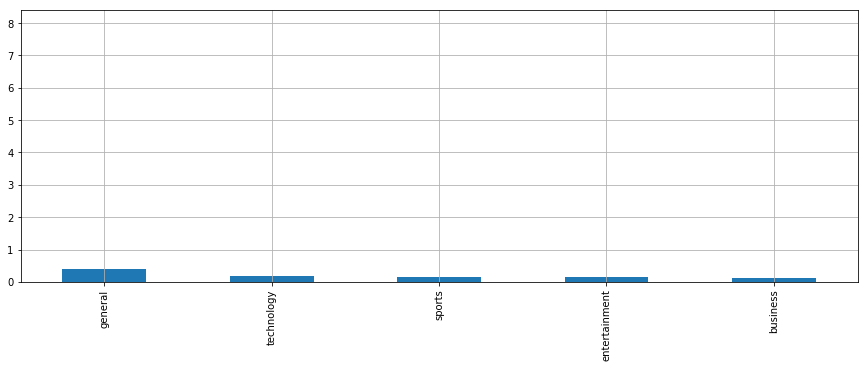

In [55]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from matplotlib import pyplot as plt

import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import numpy as np

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

data = pd.read_csv('data/news.csv')
print(data.shape)

data.head(3)

data.category.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

data = data.drop_duplicates('description')

data = data[~data['description'].isnull()]
print(data.shape)

data = data[(data.description.map(len) > 140) & (data.description.map(len) <= 300)]
data.reset_index(inplace=True, drop=True)

print(data.shape)

data.description.map(len).hist(figsize=(15, 5), bins=100)

data = data.sample(120, random_state=42)
data.reset_index(inplace=True, drop=True)

data.head(2)

In [42]:
import functools

stop_words = []

f = open('data/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

print(len(stop_words))

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(functools.reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

data['description'] = data['description'].map(lambda d: str(d))
data['tokens'] = data['description'].progress_map(lambda d: tokenizer(d))

for descripition, tokens in zip(data['description'].head(5), data['tokens'].head(5)):
    print('description:', descripition)
    print('tokens:', tokens)
    print() 
    
def keywords(category):
    tokens = data[data['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

for category in set(data['category']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

2


description: Scientists may have found a potential cure for anxiety after isolating and boosting a molecule in the brains of rhesus monkeys.

Andrew Fox, a researcher at UC Davis, and co-author ...
tokens: ['scientists', 'may', 'have', 'found', 'a', 'potential', 'cure', 'for', 'anxiety', 'after', 'isolating', 'and', 'boosting', 'a', 'molecule', 'in', 'the', 'brains', 'of', 'rhesus', 'monkeys', 'andrew', 'fox', 'a', 'researcher', 'at', 'uc', 'davis', 'and', 'co', 'author']

description: Sen. Kamala Harris (D-CA) has continued her decline in the 2020 Democrat presidential primary race, falling to sixth place among early state Democrat primary voters in the latest poll. A new poll by Morning Consult reveals how Harris has dropped
tokens: ['sen', 'kamala', 'harris', 'd', 'ca', 'has', 'continued', 'her', 'decline', 'in', 'the', 'democrat', 'presidential', 'primary', 'race', 'falling', 'to', 'sixth', 'place', 'among', 'early', 'state', 'democrat', 'primary', 'voters', 'in', 'the', 'latest', 

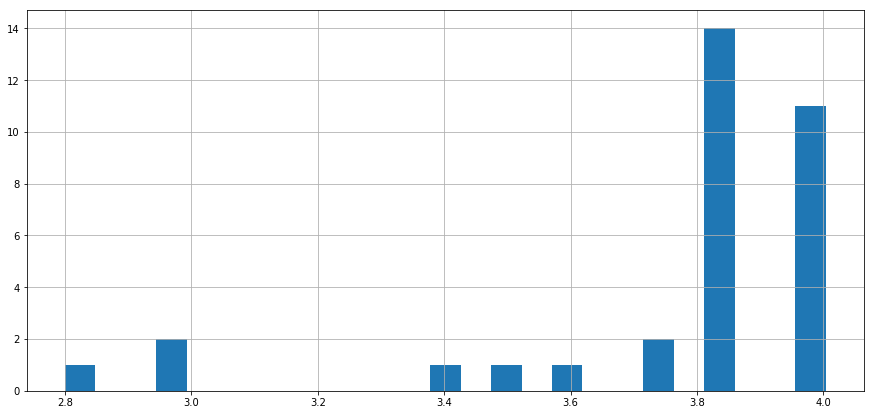

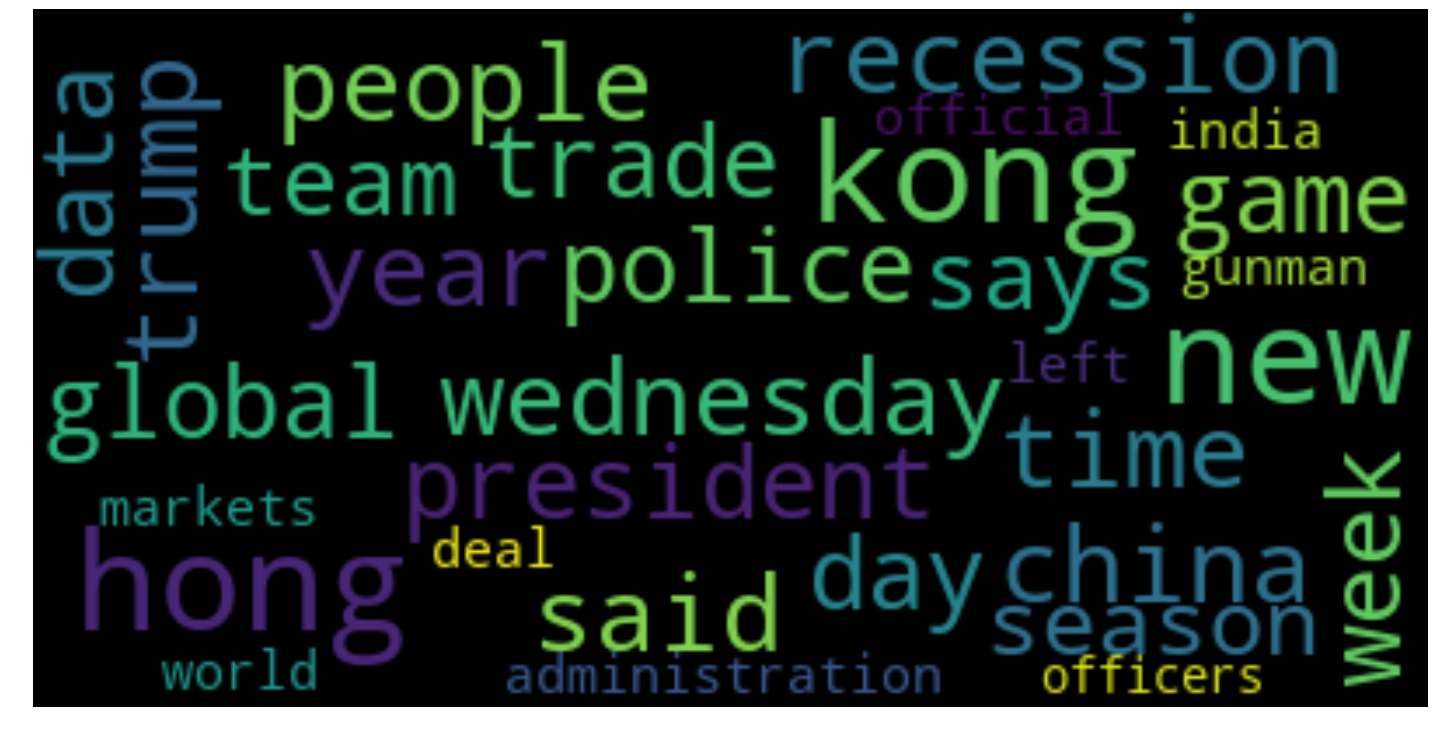

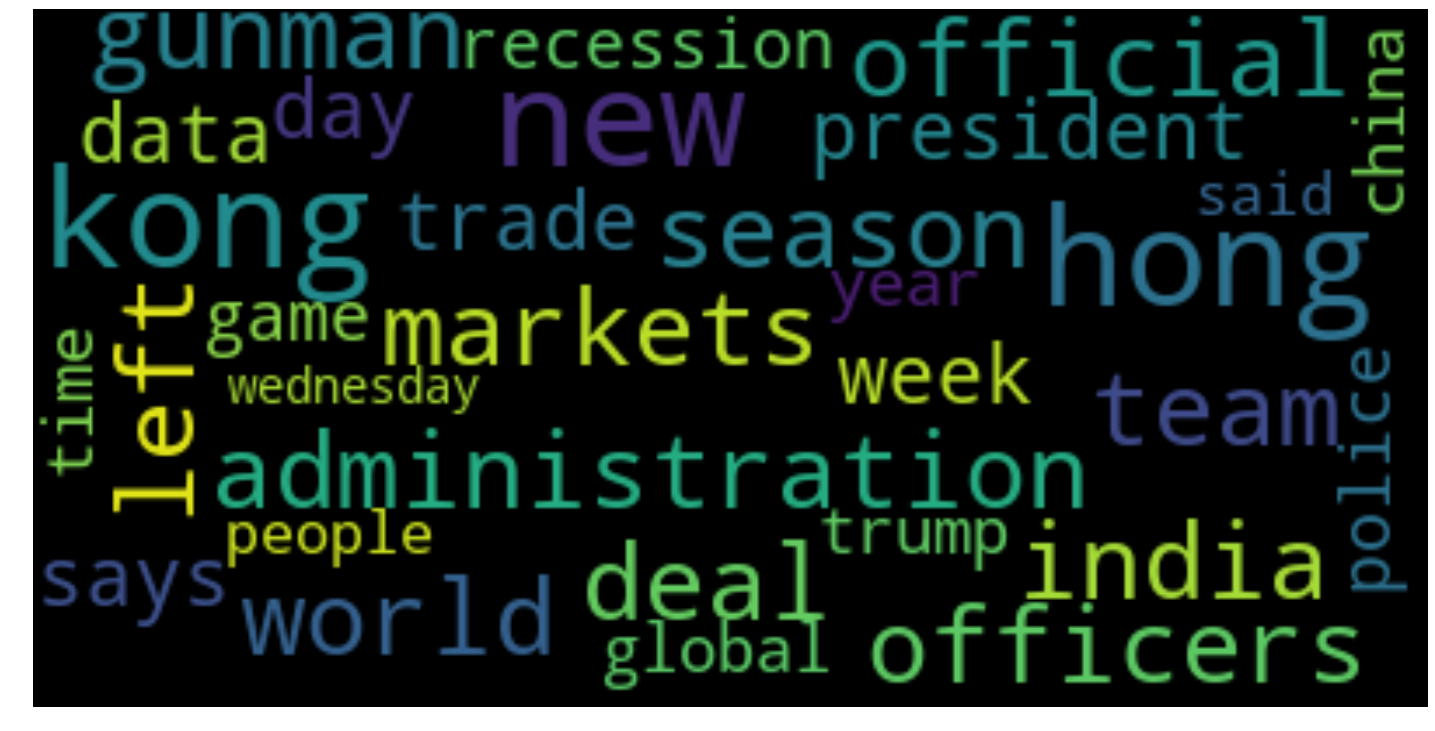

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 0.486615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.382191
[t-SNE] KL divergence after 500 iterations: 0.414638
(120, 2)


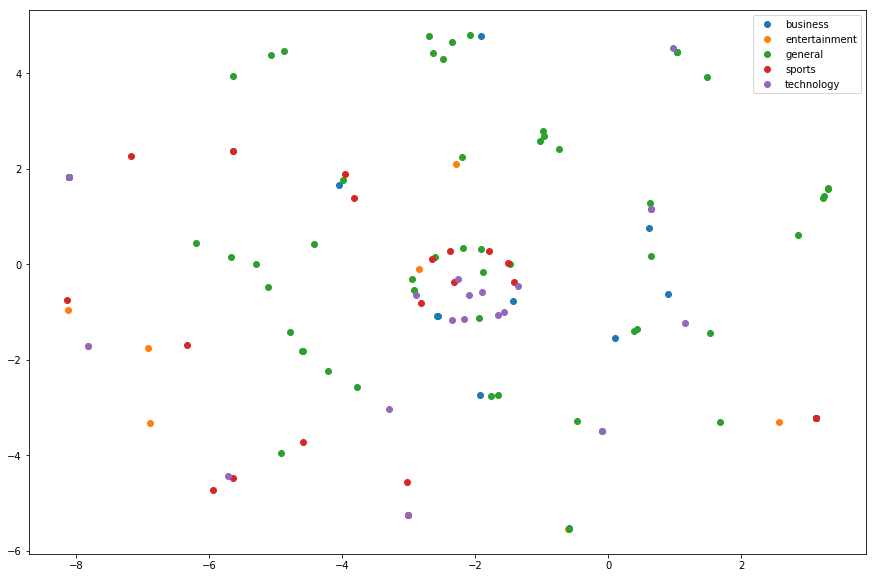

Loading BokehJS ...

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))

vz.shape

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

tfidf.tfidf.hist(bins=25, figsize=(15,7))

from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30, random_state=0)
svd_tfidf = svd.fit_transform(vz)

svd_tfidf.shape

run = True
if run:
# run this (takes times)
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['category'] = data['category']
    tsne_tfidf_df['description'] = data['description']
    tsne_tfidf_df.to_csv('data/tsne_tfidf.csv', encoding='utf-8', index=False)
else:
# or import the dataset directly
    tsne_tfidf_df = pd.read_csv('data/tsne_tfidf.csv')
    
groups = tsne_tfidf_df.groupby('category')
fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'category', 'transform': color_map}, 
                   legend='category', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category":"@category"}

show(plot_tfidf)